In [2]:
import os
import shutil
import time
from datetime import timedelta
from importlib import reload
from pathlib import Path

import numpy as np
import tensorflow as tf
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import solver; reload(solver)
import initializers; reload(initializers)
import plotter; reload(plotter)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


2021-12-02 17:29:23.559105: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# some directories definition
base_dir = '/Users/IllarionK/Projects/master_degree'
if not os.path.exists(base_dir):
    base_dir = '/src'
frames_dir = os.path.join(base_dir, 'frames')
os.makedirs(frames_dir, exist_ok=True)
video_dir = os.path.join(base_dir, 'videos')
os.makedirs(video_dir, exist_ok=True)

## Variables definition

In [6]:
SECONDS_TO_SIMULATE = 100
NORM_LENGTH = 1
NORM_LENGTH_X = NORM_LENGTH * 4
NORM_LENGTH_Y = NORM_LENGTH * 1
SCALE = 100
LENGTH_X  = NORM_LENGTH_X * SCALE
LENGTH_Y  = NORM_LENGTH_Y * SCALE
N_STEPS = SECONDS_TO_SIMULATE * SCALE

### Object parameters
OBJ_CENTER_X = LENGTH_X / 4
OBJ_CENTER_Y = LENGTH_Y / 2
# X.shape: (LENGTH_Y, LENGTH_X) Y shape: (LENGTH_Y, LENGTH_X)
X, Y = np.meshgrid(range(LENGTH_X), range(LENGTH_Y))
# INFO: shape the same as all space, but only partially filled with object
SHAPE = 'PLATE'
if SHAPE == 'SQUARE':
    NORM_SQUARE_EDGE = OBJ_D = 0.1
    SQUARE_EDGE = int(NORM_SQUARE_EDGE * SCALE)
    OBJECT_MASK = np.logical_and(
        abs(X - OBJ_CENTER_X) - SQUARE_EDGE < 0,
        abs(Y - OBJ_CENTER_Y) - SQUARE_EDGE < 0
    )
elif SHAPE == 'CYLINDER':
    NORM_CYLINDER_RADIUS = 0.125
    OBJ_D = NORM_CYLINDER_RADIUS * 2
    CYLINDER_RADIUS = int(NORM_CYLINDER_RADIUS * SCALE)
    # True within object boundaries
    OBJECT_MASK = (X - OBJ_CENTER_X) ** 2 + (Y - OBJ_CENTER_Y) ** 2 < (CYLINDER_RADIUS) ** 2
    
elif shape == 'PLATE':
    NORM_PLATE_SIZE = OBJ_D = 0.1
    PLATE_SIZE = int(NORM_PLATE_SIZE * SCALE)
    OBJECT_MASK = np.logical_and(
            abs(X - OBJ_CENTER_X) == 0,
            abs(Y - OBJ_CENTER_Y) - PLATE_SIZE < 0
        )
    

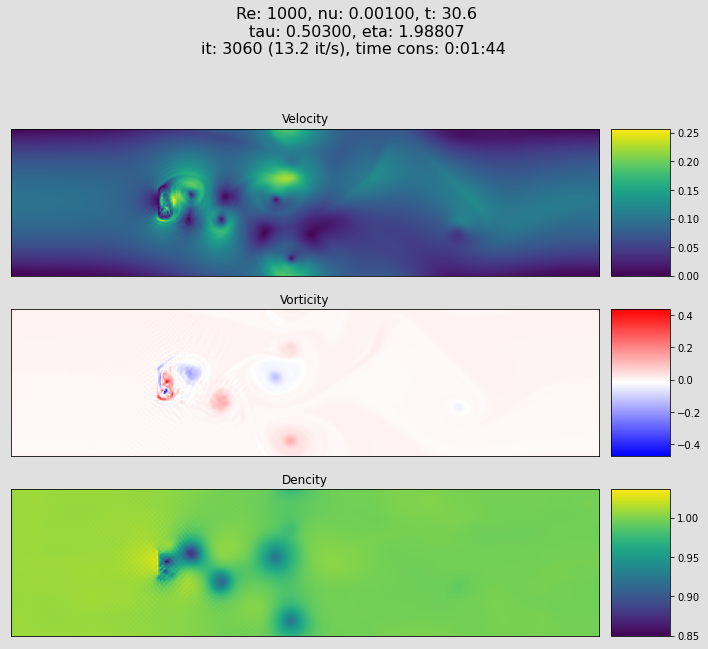

In [ ]:
REs = [10, 60, 100, 200, 500, 1000][::-1]
REs = [1000]
PLOT = True
SAVE_RES = False
for RE in REs:
    nu, tau, omega = initializers.calc_init_params(
        scale=SCALE,
        Re=RE,
        D=OBJ_D,
    )
    print(f"nu: {nu}")
    print(f"tau: {tau}")
    print(f"omega: {omega:.5f}")

    def prep_figure():
        fig, axes = plt.subplots(3, figsize=(10, 10))
        fig.patch.set_facecolor('#E0E0E0')
        fig.suptitle(f'Re: {RE}', fontsize=16)
        for ax in axes:
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')
        fig.tight_layout()
        return fig, axes
    
    bwr_cmap = plt.cm.bwr.copy()
    bwr_cmap.set_bad('black')
    
    if PLOT:
        fig, axes = prep_figure()
    if SAVE_RES:
        res_frame_dir = os.path.join(frames_dir + f'_{SHAPE}', f"{RE}_{SCALE}")
        if os.path.exists(res_frame_dir):
            shutil.rmtree(res_frame_dir)
        Path(res_frame_dir).mkdir(exist_ok=True, parents=True)

    F = initializers.init_poiseuille(
        length_x=LENGTH_X,
        length_y=LENGTH_Y
    )
    first_col = np.copy(F[:, 0, :])
    last_col = np.copy(F[:, -1, :])
    wide_F = np.zeros((F.shape[0] + 2, F.shape[1] + 2, 9))
    start = time.time()
    global_start_time = time.time()
    
    first_step = True
    cbars = []
    for it in tqdm(range(N_STEPS), disable=(PLOT or SAVE_RES)):
        F = solver.calc(
            F, wide_F,
            obj_mask_np=OBJECT_MASK.astype(np.uint8),
            tau=tau,
        )
        # TODO: move this inside calculation method
        # TODO: or fix copied columns at the wide_F
        F[:, 0, :] = first_col
        F[:, -1, :] = last_col

        if (it % (SCALE / 5) == 0 or it == N_STEPS - 1) and (PLOT or SAVE_RES):
            end = time.time()
            plot_it_per_sec = 10 / (end - start)
            start = end
            time_cons = str(timedelta(seconds=time.time() - global_start_time)).split(".")[0]
            if SAVE_RES:
                fig, axes = prep_figure()
            plot_results = plotter.pre_plot(F)
            titles = ['Velocity', 'Vorticity', 'Dencity']
            cmaps = [None, bwr_cmap, None]

            u, vorticity, rho = plot_results

            fig.suptitle(
                (
                    f"Re: {RE}, nu: {nu:.5f}, t: {it / SCALE:.1f}"
                    f"\ntau: {tau:.5f}, eta: {1 / tau:.5f}"
                    f"\nit: {it} ({plot_it_per_sec:.1f} it/s), time cons: {time_cons} "
                ),
                fontsize=16)
            fig.tight_layout()
#             for item in cbars:
#                 item.remove()
#             cbars = []
            for idx, ax, title, img, cmap in zip([0, 1, 2], axes, titles, plot_results, cmaps):
                ax.cla()
                ax.set_title(f"{title}")
                if title == 'Vorticity':
                    diplayed_im = ax.imshow(img, cmap=cmap, vmin=-.1, vmax=.1)
                if title == 'Dencity':
                    diplayed_im = ax.imshow(img, cmap=cmap)
                else:
                    diplayed_im = ax.imshow(img, cmap=cmap)

                if first_step or SAVE_RES:
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes('right', size='10%', pad="2%")
                    cbars.append(fig.colorbar(diplayed_im, cax=cax, orientation='vertical'))
                else:
                    cbars[idx].vmin=img.min()
                    cbars[idx].vmax=img.max()
                    cbars[idx].update_normal(diplayed_im)
            first_step = False

            if PLOT:
                display(fig)
            clear_output(wait=True)
            if SAVE_RES:
                pylab.savefig(
                    os.path.join(res_frame_dir, str(it)),
                    facecolor=fig.get_facecolor(),
                    transparent=False
                )
            plt.pause(0.001)
